In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms

import helper

In [2]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

Here we can see one of the images.

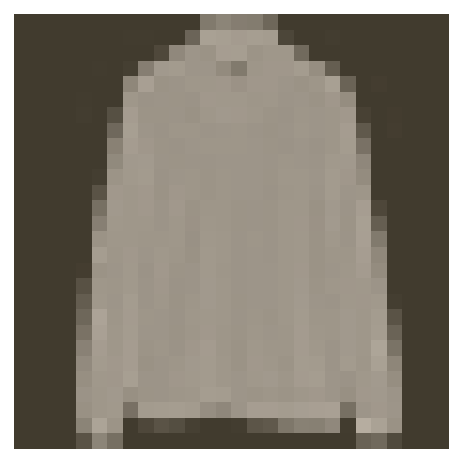

In [3]:
image, label = next(iter(trainloader))
helper.imshow(image[0,:])

# Train a Network

In [4]:
model = nn.Sequential(nn.Linear(784,256),
                     nn.ReLU(),
                     nn.Dropout(p=0.2),
                     nn.Linear(256,128),
                     nn.ReLU(),
                     nn.Dropout(p=0.2),
                     nn.Linear(128,10),
                     nn.LogSoftmax(dim=1))

In [5]:
def model_classifier(model, trainloader, testloader, learnrate):

    criterion = nn.NLLLoss()
    optimizer = optim.Adam(model.parameters(), lr=learnrate)

    steps = 0
    print_every = 50
    epochs = 2
    for i in range(epochs):
        running_loss = 0
        for images, labels in trainloader:
            images = images.view(len(images),-1)
            logps = model(images)
            loss = criterion(logps, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            steps += 1

            if steps % print_every == 0:
                accuracy = 0
                loss_test = 0
                with torch.no_grad():
                    model.eval()
                    for images, labels in testloader:
                        images = images.view(len(images), -1)
                        logps_test = model(images)
                        loss_test += criterion(logps_test, labels)

                        ps_test = torch.exp(logps_test)
                        top_ps, top_class = ps_test.topk(1, dim=1)
                        equals = top_class == labels.view(*top_class.shape)
                        accuracy += torch.mean(equals.type(torch.FloatTensor))

                model.train()

                print(f'Epoch: {i+1}/{epochs} ',
                      f'Training Loss: {running_loss/print_every:.3f} ',
                      f'Test Loss: {loss_test/len(testloader):.3f} ',
                      f'Test Accuracy: {accuracy/len(testloader):.3f}')
                running_loss = 0
    return model

Train the Model and Update Weights

In [6]:
model = model_classifier(model, trainloader, testloader, learnrate = 0.001)

Epoch: 1/2  Training Loss: 1.140  Test Loss: 0.696  Test Accuracy: 0.747
Epoch: 1/2  Training Loss: 0.691  Test Loss: 0.588  Test Accuracy: 0.779
Epoch: 1/2  Training Loss: 0.651  Test Loss: 0.580  Test Accuracy: 0.785
Epoch: 1/2  Training Loss: 0.580  Test Loss: 0.521  Test Accuracy: 0.806
Epoch: 1/2  Training Loss: 0.535  Test Loss: 0.567  Test Accuracy: 0.788
Epoch: 1/2  Training Loss: 0.535  Test Loss: 0.559  Test Accuracy: 0.789
Epoch: 1/2  Training Loss: 0.526  Test Loss: 0.498  Test Accuracy: 0.816
Epoch: 1/2  Training Loss: 0.509  Test Loss: 0.509  Test Accuracy: 0.816
Epoch: 1/2  Training Loss: 0.492  Test Loss: 0.484  Test Accuracy: 0.823
Epoch: 1/2  Training Loss: 0.495  Test Loss: 0.464  Test Accuracy: 0.828
Epoch: 1/2  Training Loss: 0.498  Test Loss: 0.470  Test Accuracy: 0.829
Epoch: 1/2  Training Loss: 0.468  Test Loss: 0.483  Test Accuracy: 0.823
Epoch: 1/2  Training Loss: 0.472  Test Loss: 0.464  Test Accuracy: 0.830
Epoch: 1/2  Training Loss: 0.459  Test Loss: 0.434 

## Saving and loading networks

It's impractical to train a network every time you need to use it. Instead, we can save trained networks then load them later to train more or use them for predictions.

The parameters for PyTorch networks are stored in a model's state_dict. We can see the state dict contains the weight and bias matrices for each of our layers.

In [7]:
print("Our model: \n\n", model, '\n')
print("The State Dict Keys \n\n", model.state_dict().keys())
print("\n Updated Weights & Bias \n\n", model.state_dict())

Our model: 

 Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.2, inplace=False)
  (6): Linear(in_features=128, out_features=10, bias=True)
  (7): LogSoftmax(dim=1)
) 

The State Dict Keys 

 odict_keys(['0.weight', '0.bias', '3.weight', '3.bias', '6.weight', '6.bias'])

 Updated Weights & Bias 

 OrderedDict([('0.weight', tensor([[-1.8237e-02, -1.2456e-02, -3.3074e-02,  ..., -3.3185e-02,
          1.2241e-05,  3.2015e-02],
        [-5.7487e-02, -1.3906e-02, -4.4339e-02,  ..., -6.6442e-02,
         -1.5064e-03, -1.3628e-02],
        [-3.9085e-02, -5.3777e-02, -5.3834e-03,  ..., -3.5771e-02,
         -5.1605e-02, -5.8616e-02],
        ...,
        [ 3.0376e-02,  2.0349e-02,  8.2986e-03,  ..., -5.8738e-03,
          2.3354e-02,  1.4291e-03],
        [ 5.3443e-02,  4.9977e-02,  2.0228e-02,  ...,  2.2779e-02,
          4.1622

We can save state_dict of trained model to the file 'model_save.pth'

In [8]:
torch.save(model.state_dict(), "model_save.pth")

###### Define a new model with the same dimensions

In [15]:
model1 = nn.Sequential(nn.Linear(784,256),
                     nn.ReLU(),
                     nn.Dropout(p=0.2),
                     nn.Linear(256,128),
                     nn.ReLU(),
                     nn.Dropout(p=0.2),
                     nn.Linear(128,10),
                     nn.LogSoftmax(dim=1))

Randomly initial weights and bias

In [16]:
print("Random (Initial) Weights & Bias \n\n", model1.state_dict())

Random (Initial) Weights & Bias 

 OrderedDict([('0.weight', tensor([[ 2.8938e-02,  3.4191e-02,  2.8179e-02,  ...,  3.6585e-03,
         -4.1004e-03, -2.6044e-05],
        [-1.4645e-02, -2.5215e-02, -3.3820e-02,  ...,  1.2206e-02,
          3.5478e-02, -1.6743e-02],
        [ 1.7446e-02, -3.0919e-02, -2.8210e-02,  ..., -3.2175e-02,
          1.7067e-02,  2.3889e-02],
        ...,
        [-1.2997e-02,  2.0965e-02,  1.0596e-02,  ...,  1.1728e-02,
         -7.1311e-03,  2.2190e-02],
        [-1.5601e-02, -1.9358e-03,  6.2410e-03,  ..., -2.9804e-02,
          2.6205e-02, -5.0250e-03],
        [-6.0843e-03,  7.2321e-03, -2.3176e-02,  ...,  6.7067e-03,
          8.6357e-03,  2.7227e-02]])), ('0.bias', tensor([-2.4501e-02,  2.3262e-03, -9.8405e-04,  3.4239e-02,  3.4529e-02,
         2.1217e-02,  2.4215e-02,  2.4014e-02, -2.6450e-02,  7.8406e-03,
         1.2935e-03,  1.6229e-02,  3.4904e-02,  2.6604e-02,  1.4109e-02,
         2.5701e-02, -6.6797e-03, -4.3051e-03, -1.9710e-02, -3.5110e-02,
  

Load the state dict with torch.load

In [17]:
state_dict_saved = torch.load('model_save.pth')
print(state_dict_saved.keys())

odict_keys(['0.weight', '0.bias', '3.weight', '3.bias', '6.weight', '6.bias'])


Loading the state dict into the network

In [18]:
model1.load_state_dict(state_dict_saved)

<All keys matched successfully>

In [19]:
print("Weights & Bias \n\n", model1.state_dict())

Weights & Bias 

 OrderedDict([('0.weight', tensor([[-1.8237e-02, -1.2456e-02, -3.3074e-02,  ..., -3.3185e-02,
          1.2241e-05,  3.2015e-02],
        [-5.7487e-02, -1.3906e-02, -4.4339e-02,  ..., -6.6442e-02,
         -1.5064e-03, -1.3628e-02],
        [-3.9085e-02, -5.3777e-02, -5.3834e-03,  ..., -3.5771e-02,
         -5.1605e-02, -5.8616e-02],
        ...,
        [ 3.0376e-02,  2.0349e-02,  8.2986e-03,  ..., -5.8738e-03,
          2.3354e-02,  1.4291e-03],
        [ 5.3443e-02,  4.9977e-02,  2.0228e-02,  ...,  2.2779e-02,
          4.1622e-02, -5.8922e-03],
        [-1.1122e-02, -1.5371e-02,  2.1072e-02,  ...,  2.7892e-03,
         -6.4000e-03, -2.3272e-02]])), ('0.bias', tensor([-2.1945e-02, -3.8062e-03,  7.0595e-02, -3.9122e-02, -2.7458e-02,
        -3.7317e-02, -3.5384e-02, -5.4028e-02, -3.5895e-02, -1.0654e-02,
         4.6649e-03, -2.0078e-02, -6.7733e-03, -4.0449e-02, -3.6234e-02,
        -3.6078e-02, -1.6943e-02, -3.4679e-02,  4.3581e-03,  3.3778e-03,
        -3.2545e-02

Seems pretty straightforward, but as usual it's a bit more complicated. Loading the state dict works only if the model architecture is exactly the same as the saved model architecture. If we create a model with a different architecture, this fails.

In [20]:
model2 = nn.Sequential(nn.Linear(784,250),
                     nn.ReLU(),
                     nn.Dropout(p=0.2),
                     nn.Linear(250,125),
                     nn.ReLU(),
                     nn.Dropout(p=0.2),
                     nn.Linear(125,10),
                     nn.LogSoftmax(dim=1))

In [21]:
# This will throw an error because the tensor sizes are wrong!
model2.load_state_dict(state_dict_saved)

RuntimeError: Error(s) in loading state_dict for Sequential:
	size mismatch for 0.weight: copying a param with shape torch.Size([256, 784]) from checkpoint, the shape in current model is torch.Size([250, 784]).
	size mismatch for 0.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([250]).
	size mismatch for 3.weight: copying a param with shape torch.Size([128, 256]) from checkpoint, the shape in current model is torch.Size([125, 250]).
	size mismatch for 3.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([125]).
	size mismatch for 6.weight: copying a param with shape torch.Size([10, 128]) from checkpoint, the shape in current model is torch.Size([10, 125]).

# Saving and Loading Model with Model Architecture

This means we need to rebuild the model exactly as it was when trained. Information about the model architecture needs to be saved in the 'model_save.pth', along with the state dict. To do this, we build a dictionary with all the information we need to compeletely rebuild the model.

Save the model with model dimensions

In [22]:
from operator import itemgetter               # for getting specific layers (hidden layers) while saving the model

In [24]:
checkpoint = {"input_size" : 784,
              "output_size" : 10,
              "hidden_layers" : [each.out_features for each in itemgetter(0,3,6)(model)],  #0,3,6 - hidden layers with weights & bias
              "state_dict" : model.state_dict()}

In [25]:
torch.save(checkpoint, 'model_save2.pth')

Loading Model dimensions, Weights & Bias

In [26]:
checkpoint1 = torch.load('model_save2.pth')

In [27]:
in_size = checkpoint1['input_size']
out_size = checkpoint1['output_size']
hidden_size = checkpoint1['hidden_layers']

In [28]:
model3 = nn.Sequential(nn.Linear(in_size,hidden_size[0]),
                     nn.ReLU(),
                     nn.Dropout(p=0.2),
                     nn.Linear(hidden_size[0],hidden_size[1]),
                     nn.ReLU(),
                     nn.Dropout(p=0.2),
                     nn.Linear(hidden_size[1],hidden_size[2]),
                     nn.LogSoftmax(dim=1))

In [29]:
print("Random (Initial) Weights & Bias \n\n", model3.state_dict())

Random (Initial) Weights & Bias 

 OrderedDict([('0.weight', tensor([[ 0.0291,  0.0217,  0.0087,  ..., -0.0248,  0.0110, -0.0151],
        [ 0.0295, -0.0120,  0.0121,  ...,  0.0136, -0.0138,  0.0224],
        [-0.0335, -0.0272,  0.0264,  ..., -0.0069,  0.0124,  0.0038],
        ...,
        [-0.0134,  0.0320,  0.0041,  ...,  0.0284, -0.0152,  0.0179],
        [-0.0337,  0.0345,  0.0016,  ..., -0.0214, -0.0327, -0.0315],
        [-0.0256,  0.0026, -0.0003,  ...,  0.0079, -0.0068, -0.0120]])), ('0.bias', tensor([ 0.0195,  0.0122, -0.0253, -0.0272,  0.0072, -0.0012, -0.0289, -0.0324,
        -0.0054,  0.0246,  0.0087, -0.0112, -0.0088, -0.0242,  0.0173,  0.0214,
        -0.0162, -0.0122,  0.0240, -0.0288, -0.0265,  0.0030, -0.0330,  0.0311,
         0.0340, -0.0197,  0.0029,  0.0101,  0.0302,  0.0174, -0.0128,  0.0325,
         0.0165,  0.0163, -0.0041, -0.0155,  0.0349, -0.0171, -0.0177, -0.0076,
         0.0242, -0.0119, -0.0112, -0.0342, -0.0041, -0.0310, -0.0310, -0.0113,
        -0.0

In [30]:
model3.load_state_dict(checkpoint1['state_dict'])

<All keys matched successfully>

In [32]:
print("Loaded Weights & Bias \n\n", model3.state_dict())

Loaded Weights & Bias 

 OrderedDict([('0.weight', tensor([[-1.8237e-02, -1.2456e-02, -3.3074e-02,  ..., -3.3185e-02,
          1.2241e-05,  3.2015e-02],
        [-5.7487e-02, -1.3906e-02, -4.4339e-02,  ..., -6.6442e-02,
         -1.5064e-03, -1.3628e-02],
        [-3.9085e-02, -5.3777e-02, -5.3834e-03,  ..., -3.5771e-02,
         -5.1605e-02, -5.8616e-02],
        ...,
        [ 3.0376e-02,  2.0349e-02,  8.2986e-03,  ..., -5.8738e-03,
          2.3354e-02,  1.4291e-03],
        [ 5.3443e-02,  4.9977e-02,  2.0228e-02,  ...,  2.2779e-02,
          4.1622e-02, -5.8922e-03],
        [-1.1122e-02, -1.5371e-02,  2.1072e-02,  ...,  2.7892e-03,
         -6.4000e-03, -2.3272e-02]])), ('0.bias', tensor([-2.1945e-02, -3.8062e-03,  7.0595e-02, -3.9122e-02, -2.7458e-02,
        -3.7317e-02, -3.5384e-02, -5.4028e-02, -3.5895e-02, -1.0654e-02,
         4.6649e-03, -2.0078e-02, -6.7733e-03, -4.0449e-02, -3.6234e-02,
        -3.6078e-02, -1.6943e-02, -3.4679e-02,  4.3581e-03,  3.3778e-03,
        -3.2